In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import datetime as dt
import matplotlib.pyplot as plt
from glob import glob

In [2]:
df_final = pd.read_parquet('df_final.parquet.gzip')

In [3]:
df_final_pur = df_final[df_final['event_type'] == 'purchase']

In [4]:
df_final_pur

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id
7,2019-10-16 12:04:38+00:00,purchase,3601438,2053013563810775923,appliances.kitchen.washer,beko,203.410004,512935426
53,2019-10-16 12:04:39+00:00,purchase,1004750,2053013555631882655,electronics.smartphone,samsung,195.619995,560839537
84,2019-10-16 12:04:41+00:00,purchase,1004834,2053013555631882655,electronics.smartphone,samsung,173.389999,545171410
178,2019-10-16 12:04:46+00:00,purchase,1005105,2053013555631882655,electronics.smartphone,apple,1424.209961,514778102
193,2019-10-16 12:04:47+00:00,purchase,1801900,2053013554415534427,electronics.video.tv,samsung,483.459991,551965553
...,...,...,...,...,...,...,...,...
7074469,2019-10-11 17:54:34+00:00,purchase,1003235,2053013555631882655,electronics.smartphone,huawei,128.419998,559189082
7074484,2019-10-11 17:54:35+00:00,purchase,1005112,2053013555631882655,electronics.smartphone,apple,1003.849976,512404459
7074507,2019-10-11 17:54:35+00:00,purchase,1005115,2053013555631882655,electronics.smartphone,apple,1003.849976,540273893
7074511,2019-10-11 17:54:36+00:00,purchase,1002524,2053013555631882655,electronics.smartphone,apple,566.960022,533409964


In [5]:
last_timestamp = df_final_pur['event_time'].max() + dt.timedelta(days=1)

rfm = df_final_pur.groupby('user_id').agg({'event_time': lambda x : (last_timestamp - x.max()).days,
                                      'product_id' : 'count',
                                      'price' : 'sum'})

In [6]:
rfm['product_id'].value_counts()

1      153168
2       78850
3       22244
4       17082
5        6960
        ...  
87          1
141         1
139         1
133         1
108         1
Name: product_id, Length: 137, dtype: int64

In [7]:
rfm.head(2)

,event_time,product_id,price
user_id,,,
264649825,26,2,1240.040039
340041246,21,3,575.820007


In [8]:
# 컬럼값 변경하기 
rfm.columns = ['recency', 'frequency', 'monetary']

array([[<AxesSubplot: title={'center': 'recency'}>,
        <AxesSubplot: title={'center': 'frequency'}>],
       [<AxesSubplot: title={'center': 'monetary'}>, <AxesSubplot: >]],
      dtype=object)

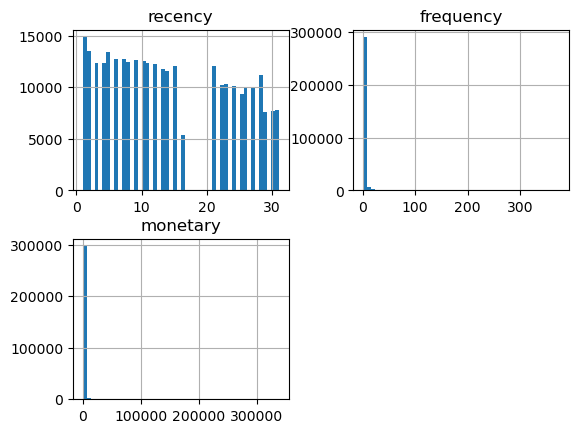

In [9]:
rfm.hist(bins=50)

In [10]:
# recency는 값이 낮을 수록 점수가 높다. 
# 최근에 구매한 고객이기 때문! 
list(range(5,0,-1))

[5, 4, 3, 2, 1]

In [11]:
# frequency와 monetary는 값이 높을 수록 높음
list(range(1,6))

[1, 2, 3, 4, 5]

In [12]:
r_labels = list(range(5,0,-1))
f_labels = list(range(1,6))
m_labels = list(range(1,6))
cut_size = 5

In [13]:
# 상대적인 계산이 필요하므로 qcut()으로 진행 
r_cut = pd.qcut(rfm['recency'].rank(method='first'), cut_size, labels=r_labels)


In [14]:
f_cut = pd.qcut(rfm['frequency'].rank(method='first'), cut_size, labels=f_labels)

In [15]:
m_cut = pd.qcut(rfm['monetary'].rank(method='first'), cut_size, labels=m_labels)

In [16]:
rfm = rfm.assign(R=r_cut, F=f_cut, M=m_cut)

In [17]:
rfm['rfm_segment'] = rfm['R'].astype(str) + rfm['F'].astype(str) + rfm['M'].astype(str)

In [18]:
rfm['rfm_score'] = rfm[['R','F','M']].sum(axis=1)

In [19]:
rfm

,recency,frequency,monetary,R,F,M,rfm_segment,rfm_score
user_id,,,,,,,,
264649825,26,2,1240.040039,1,3,5,135,9
340041246,21,3,575.820007,2,4,4,244,10
371877401,23,1,29.889999,2,1,1,211,4
384989212,14,2,82.879997,3,3,1,331,7
387300134,6,1,20.590000,4,1,1,411,6
...,...,...,...,...,...,...,...,...
566270177,1,1,75.940002,5,3,1,531,9
566272569,1,2,254.839996,5,4,3,543,12
566274637,1,1,2011.630005,5,3,5,535,13


<AxesSubplot: xlabel='rfm_segment', ylabel='rfm_score'>

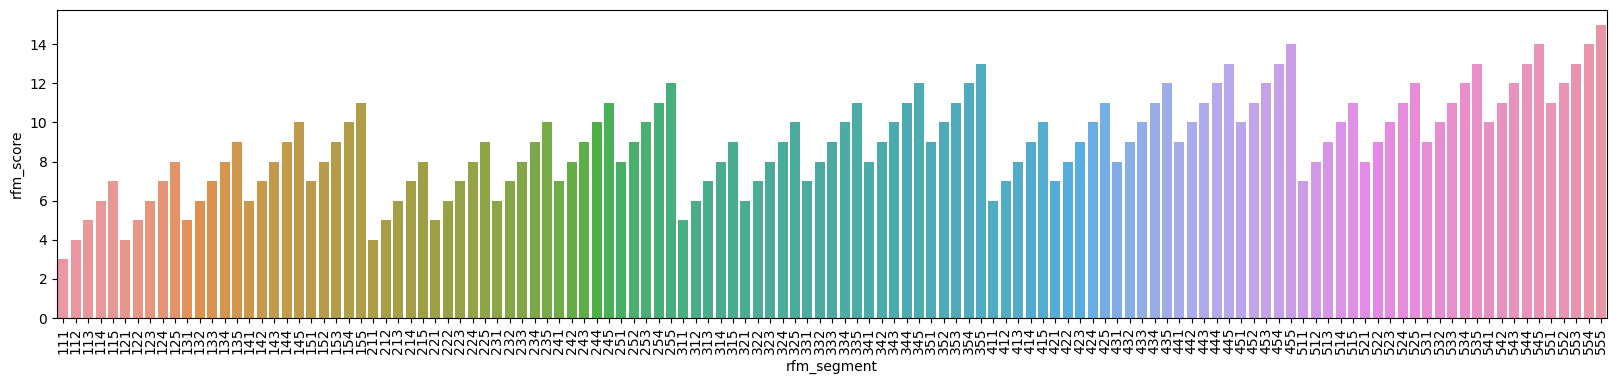

In [20]:
plt.figure(figsize=(20, 4))
plt.xticks(rotation=90)
sns.barplot(data=rfm.sort_values('rfm_segment'), x='rfm_segment', y='rfm_score')

array([[<AxesSubplot: title={'center': 'recency'}>,
        <AxesSubplot: title={'center': 'frequency'}>],
       [<AxesSubplot: title={'center': 'monetary'}>,
        <AxesSubplot: title={'center': 'R'}>],
       [<AxesSubplot: title={'center': 'F'}>,
        <AxesSubplot: title={'center': 'M'}>]], dtype=object)

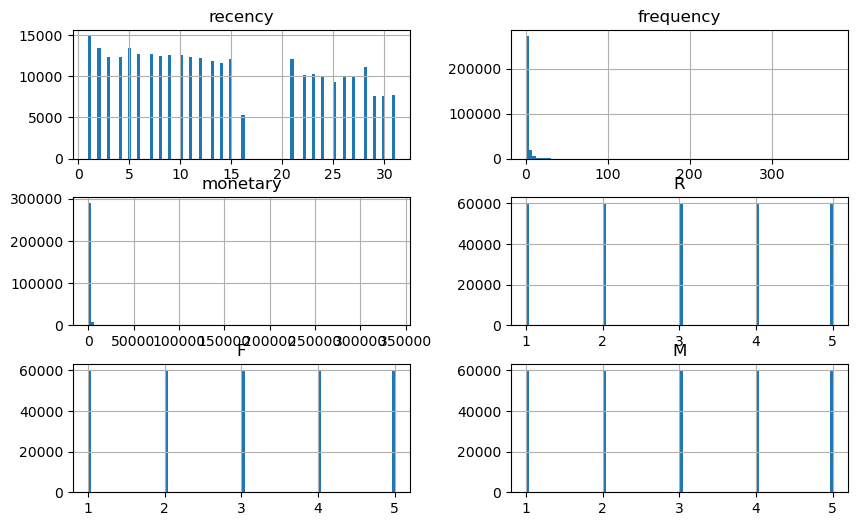

In [21]:
rfm.iloc[:, :-2].astype(float).hist(figsize=(10,6), bins=100)

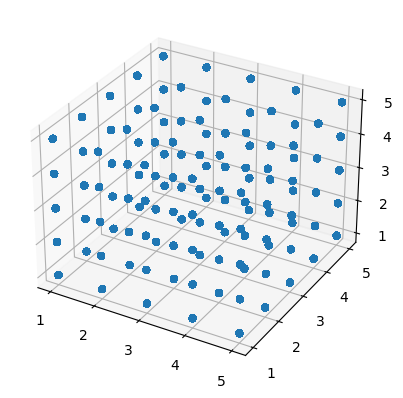

In [22]:
ax = plt.axes(projection='3d')
ax.scatter3D(rfm['R'], rfm['F'], rfm['M'])

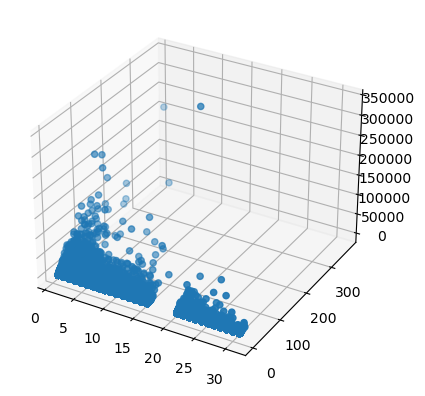

In [23]:
ax = plt.axes(projection='3d')
ax.scatter3D(rfm['recency'], rfm['frequency'], rfm['monetary'])

In [25]:
rfm_table = rfm.groupby('rfm_score').agg({'recency':'mean',
                                          'frequency' : 'mean',
                                          'monetary' : ['mean', 'sum']})
rfm_table.style.background_gradient().format('{:,.0f}')


In [26]:
class_labels = ['silver', 'gold', 'platinum']

In [27]:
rfm['rfm_class'] = pd.qcut(rfm['rfm_score'], 3, labels=class_labels)
rfm

,recency,frequency,monetary,R,F,M,rfm_segment,rfm_score,rfm_class
user_id,,,,,,,,,
264649825,26,2,1240.040039,1,3,5,135,9,gold
340041246,21,3,575.820007,2,4,4,244,10,gold
371877401,23,1,29.889999,2,1,1,211,4,silver
384989212,14,2,82.879997,3,3,1,331,7,silver
387300134,6,1,20.590000,4,1,1,411,6,silver
...,...,...,...,...,...,...,...,...,...
566270177,1,1,75.940002,5,3,1,531,9,gold
566272569,1,2,254.839996,5,4,3,543,12,platinum
566274637,1,1,2011.630005,5,3,5,535,13,platinum


In [29]:
# "RFM_class" 별로 그룹화 하고 "RFM_score" 의 describe 값을 구합니다.
# RFM_score에 따라 RFM_class 값이 잘 나뉘었는지 확인
rfm.groupby('rfm_class')['rfm_score'].describe()

,count,mean,std,min,25%,50%,75%,max
rfm_class,,,,,,,,
silver,134570.0,6.225853,1.502995,3.0,5.0,6.0,8.0,8.0
gold,69349.0,9.496330,0.499990,9.0,9.0,9.0,10.0,10.0
platinum,96681.0,12.505311,1.346564,11.0,11.0,12.0,13.0,15.0


<AxesSubplot: xlabel='rfm_class', ylabel='rfm_score'>

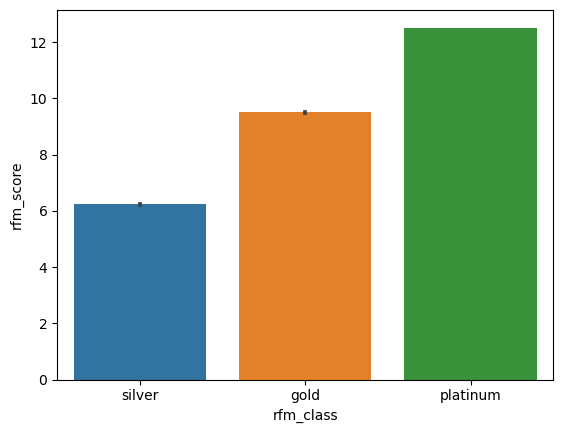

In [30]:
sns.barplot(data=rfm, x='rfm_class', y='rfm_score')

<AxesSubplot: xlabel='rfm_class', ylabel='rfm_score'>

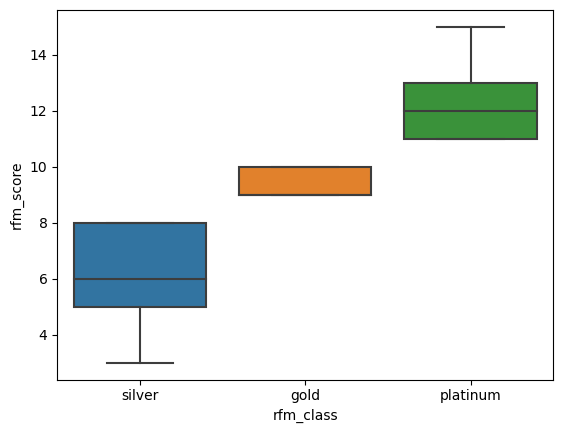

In [31]:
sns.boxplot(data=rfm, x='rfm_class', y='rfm_score')

<AxesSubplot: xlabel='R', ylabel='rfm_score'>

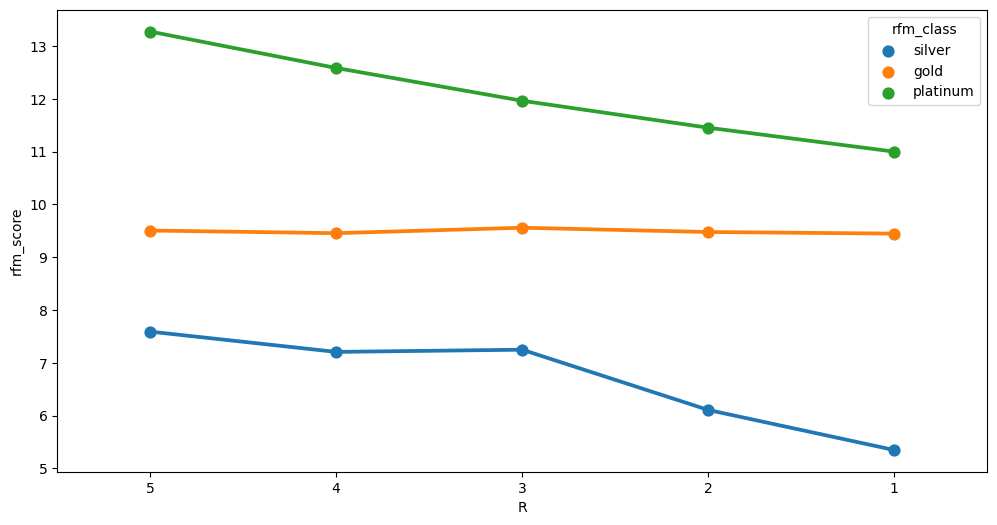

In [32]:
plt.figure(figsize=(12,6))
sns.pointplot(data=rfm, x='R', y='rfm_score', hue='rfm_class')

<AxesSubplot: xlabel='M', ylabel='rfm_score'>

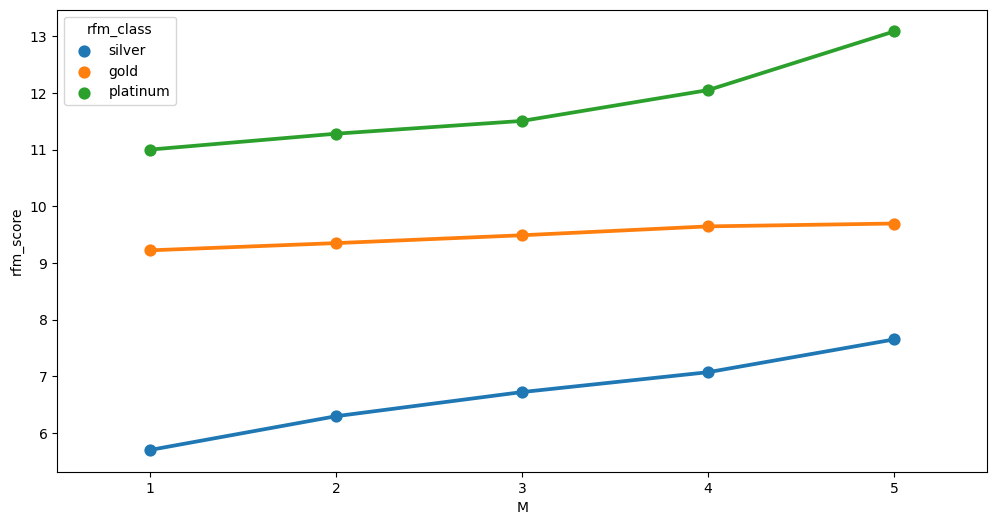

In [34]:
plt.figure(figsize=(12,6))
sns.pointplot(data=rfm, x='M', y='rfm_score', hue='rfm_class')

In [38]:
rfm.groupby('rfm_class').agg({'recency':'mean', 
                              'frequency':'mean',
                              'monetary':['mean', 'sum', 'count']}).style.background_gradient().format('{:,.0f}')

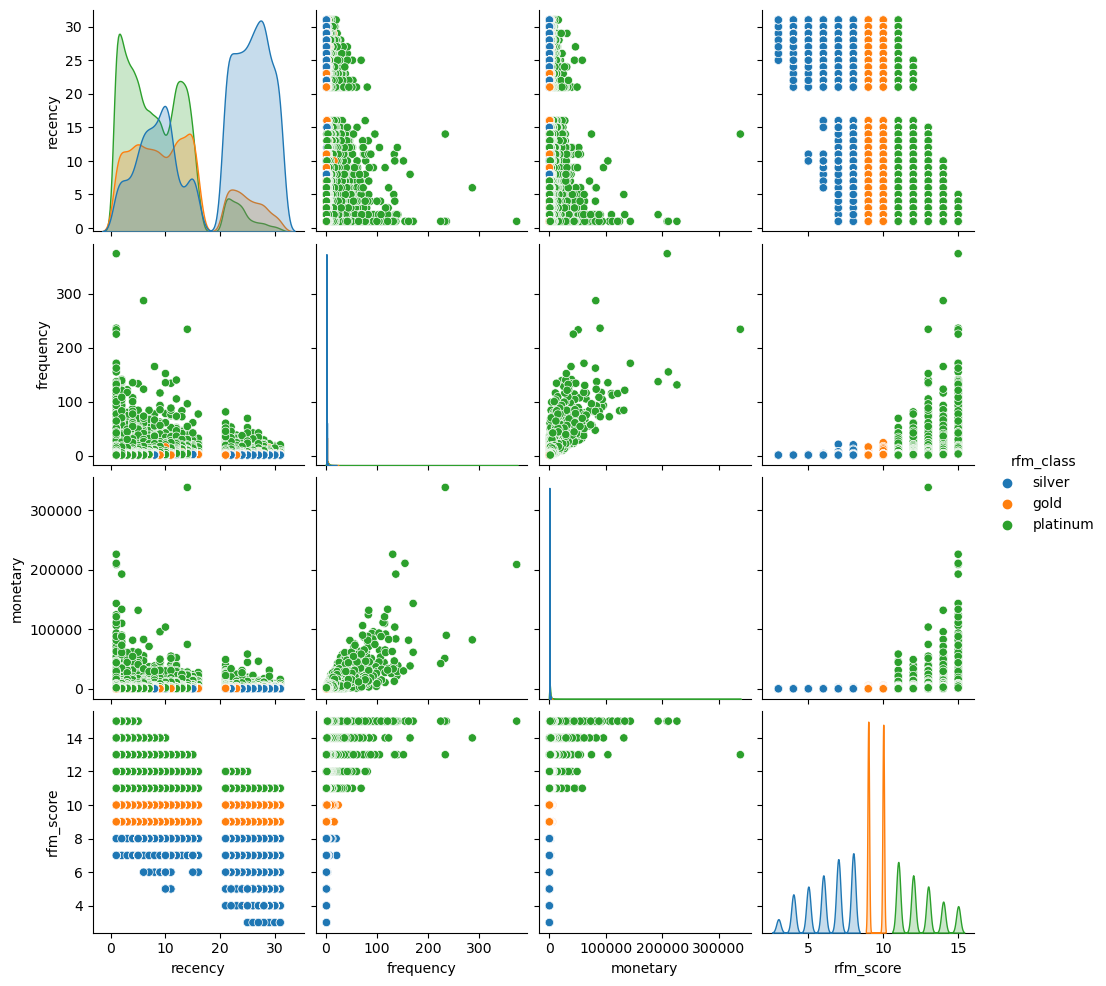

In [39]:
sns.pairplot(data=rfm, hue='rfm_class')

In [40]:
rfm

,recency,frequency,monetary,R,F,M,rfm_segment,rfm_score,rfm_class
user_id,,,,,,,,,
264649825,26,2,1240.040039,1,3,5,135,9,gold
340041246,21,3,575.820007,2,4,4,244,10,gold
371877401,23,1,29.889999,2,1,1,211,4,silver
384989212,14,2,82.879997,3,3,1,331,7,silver
387300134,6,1,20.590000,4,1,1,411,6,silver
...,...,...,...,...,...,...,...,...,...
566270177,1,1,75.940002,5,3,1,531,9,gold
566272569,1,2,254.839996,5,4,3,543,12,platinum
566274637,1,1,2011.630005,5,3,5,535,13,platinum
